# Analysis

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scikit_posthocs import posthoc_dunn


In [2]:
arb_df = pd.read_csv('../arb-contracts-final-results.csv')
eth_df = pd.read_csv('../eth-contracts-final-results.csv')
ftm_df = pd.read_csv('../ftm-contracts-final-results.csv')
opt_df = pd.read_csv('../opt-contracts-final-results.csv')
pol_df = pd.read_csv('../pol-contracts-final-results.csv')

# add column to each df to indicate the blockchain
arb_df['Blockchain'] = 'arb'
eth_df['Blockchain'] = 'eth'
ftm_df['Blockchain'] = 'ftm'
opt_df['Blockchain'] = 'opt'
pol_df['Blockchain'] = 'pol'

blockchains = ['arb', 'eth', 'ftm', 'opt', 'pol']
combined_df = pd.concat([arb_df, eth_df, ftm_df, opt_df, pol_df])


In [3]:
def create_sub_df(df, keyword):
    new_df = df.filter(regex=f'^({keyword}|Blockchain)')
    new_df.columns = new_df.columns.str.replace(keyword, '')
    return new_df

combined_metrics_df = create_sub_df(combined_df, 'metrics.')
combined_patterns_df = create_sub_df(combined_df, 'patterns.')

# rename Storage Optimization column to Storage Saver
combined_patterns_df = combined_patterns_df.rename(columns={'Storage Optimization': 'Storage Saver'})


In [4]:
def get_stats(df):
    df_stats = df.describe()
    df_stats.loc['mode'] = df.mode().iloc[0]
    df_stats = df_stats.rename(index={'50%': 'median'})
    df_stats = df_stats.drop('count')
    return df_stats

combined_stats = get_stats(combined_metrics_df)


## Metric Boxplots

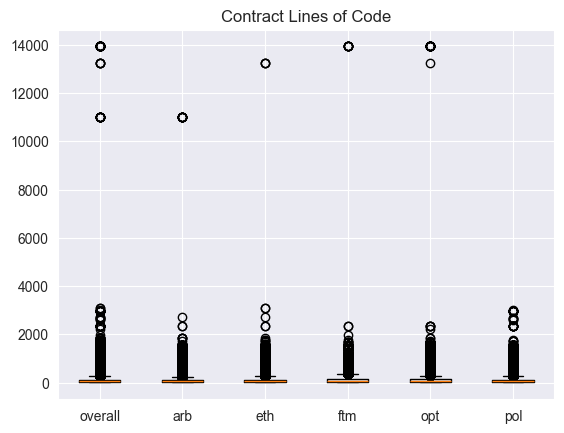

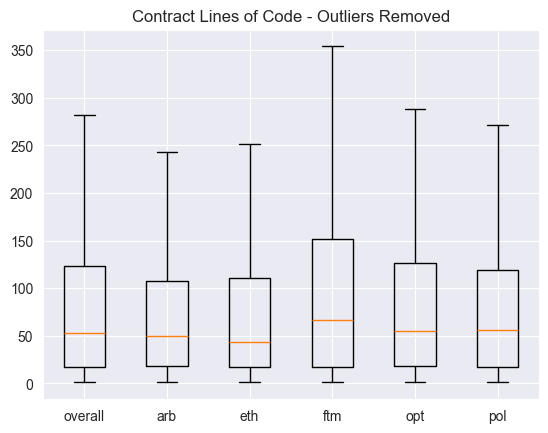

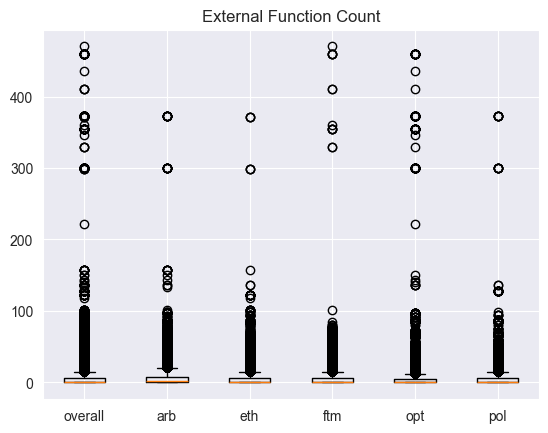

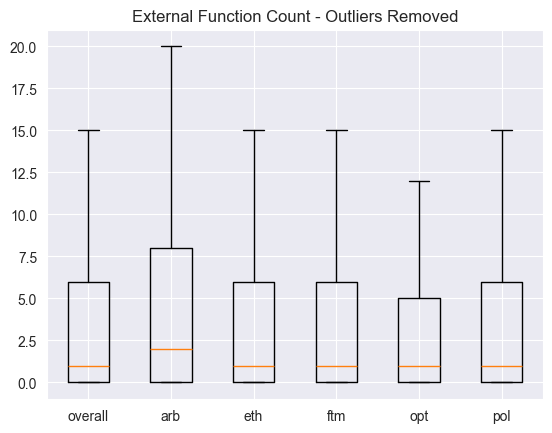

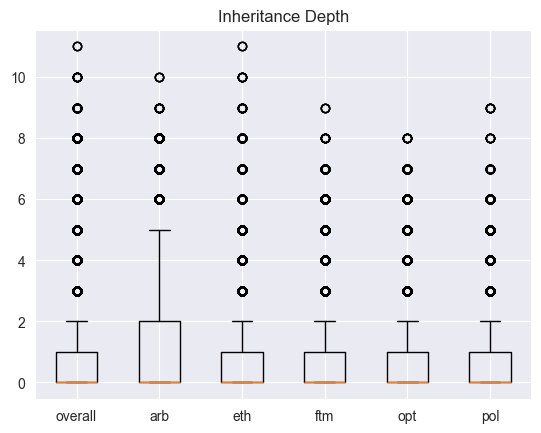

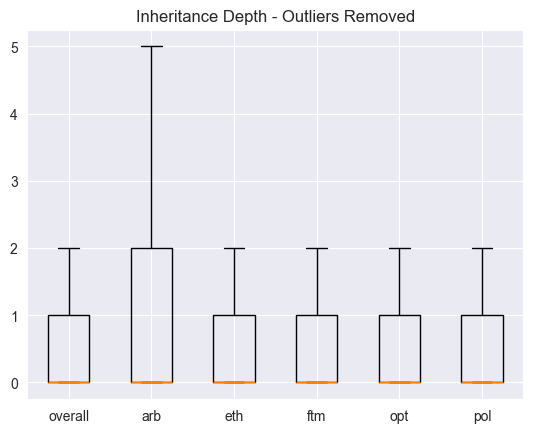

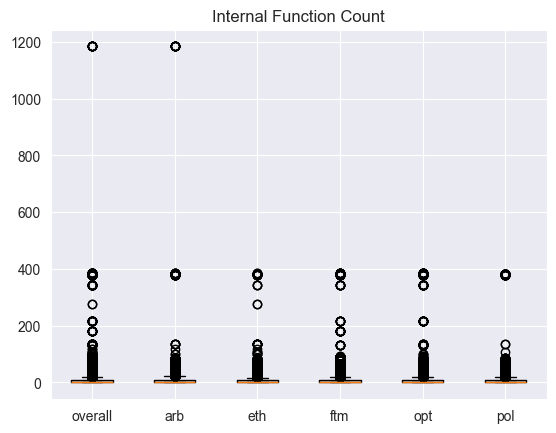

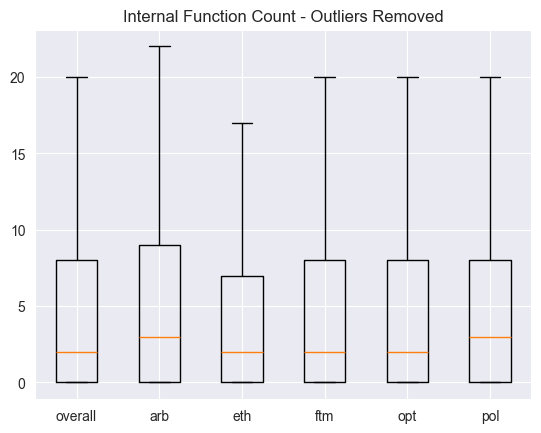

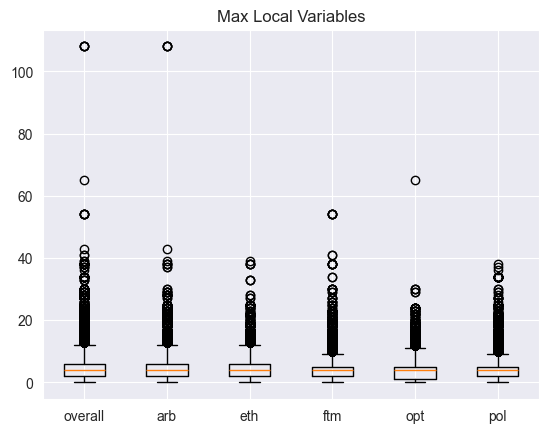

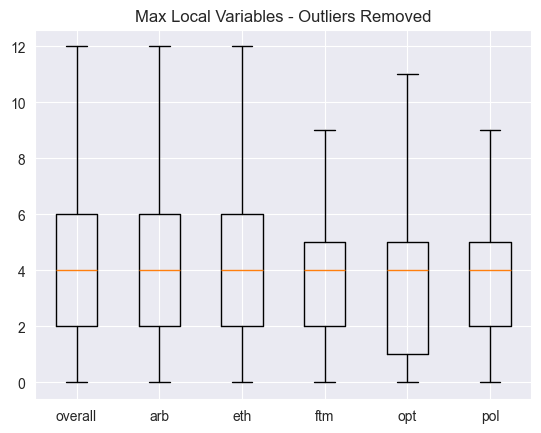

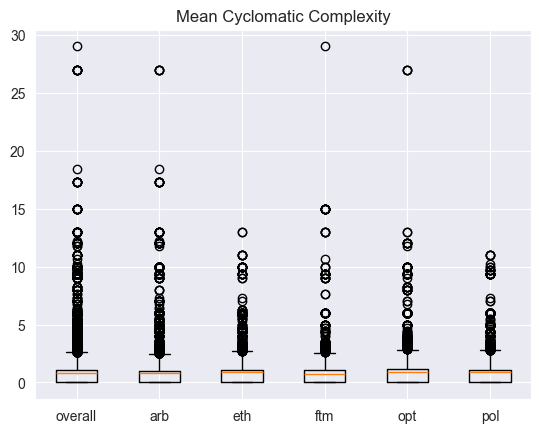

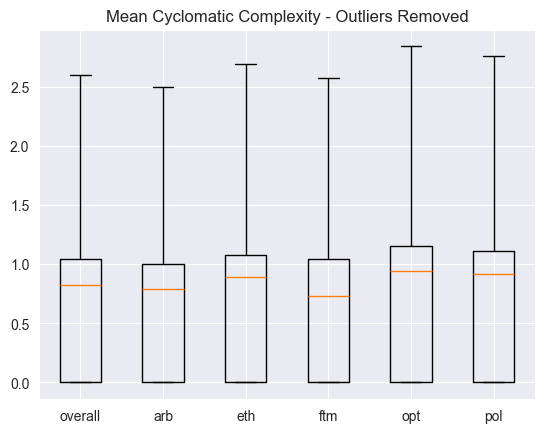

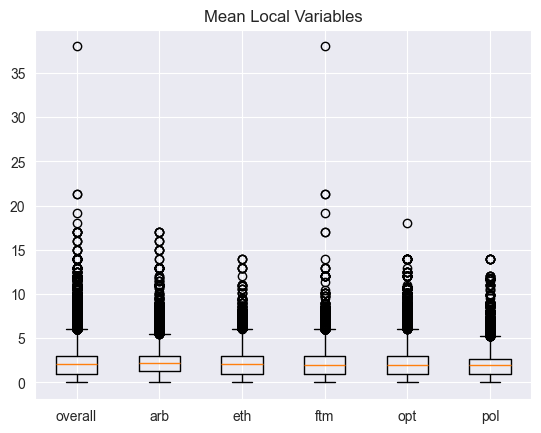

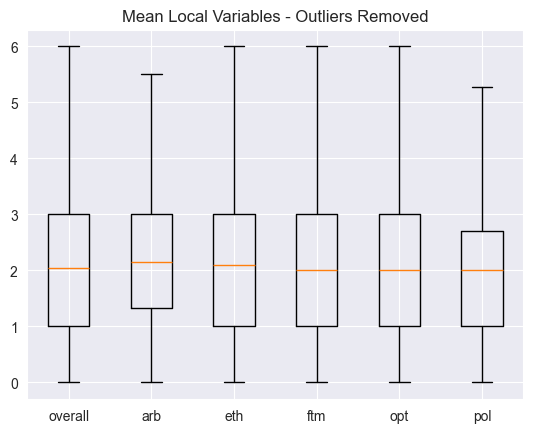

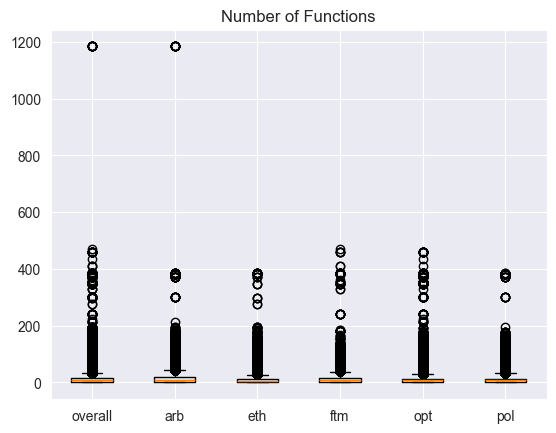

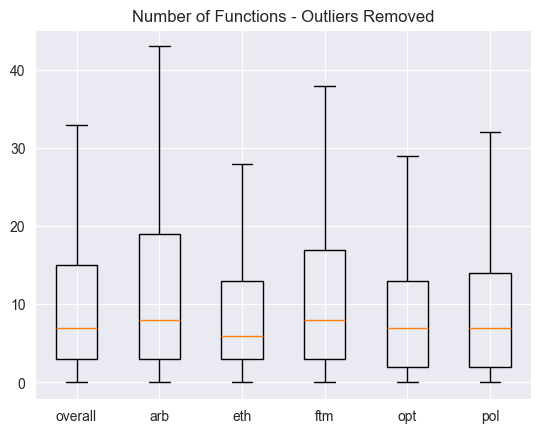

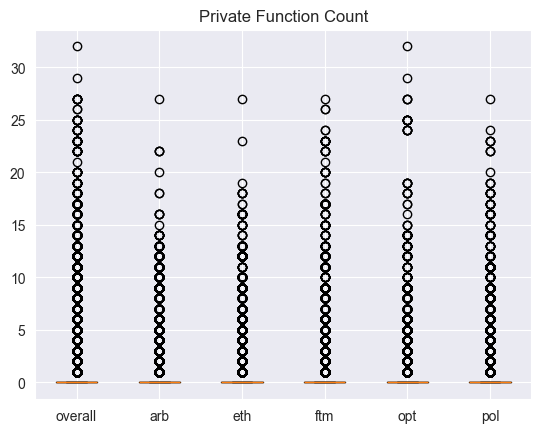

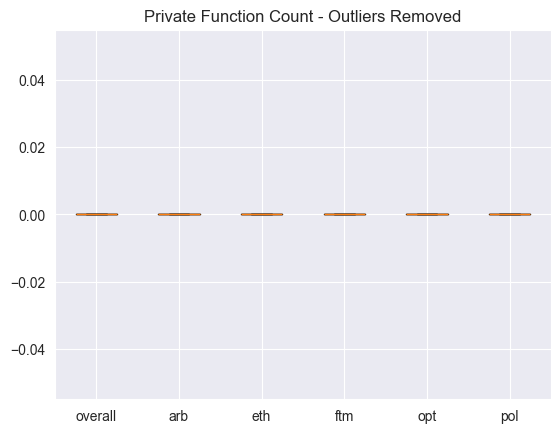

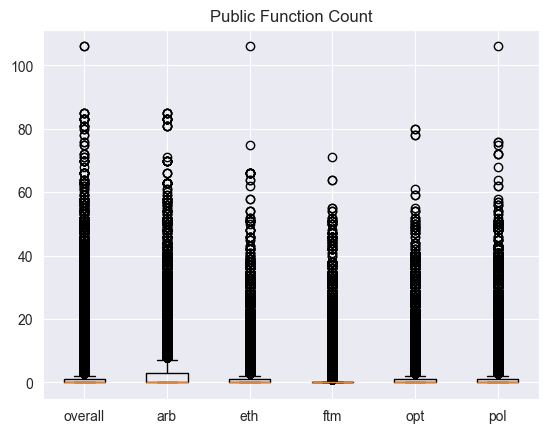

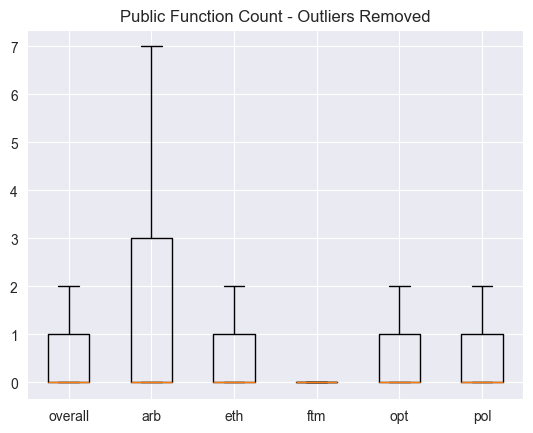

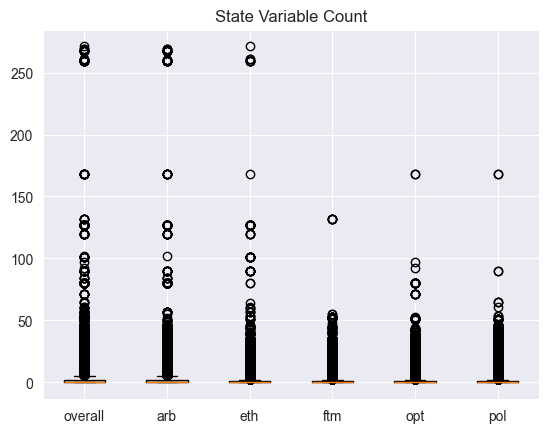

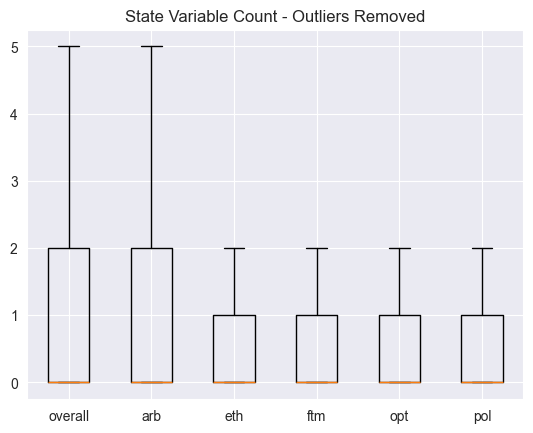

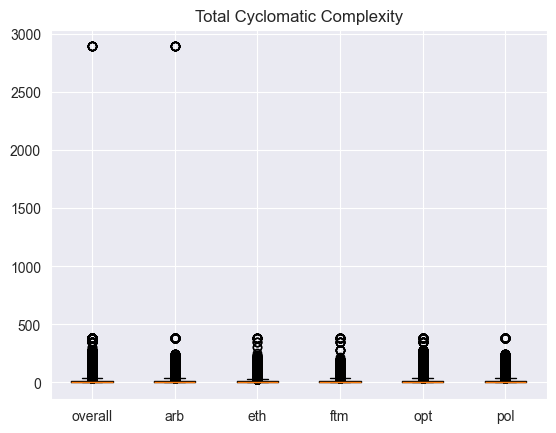

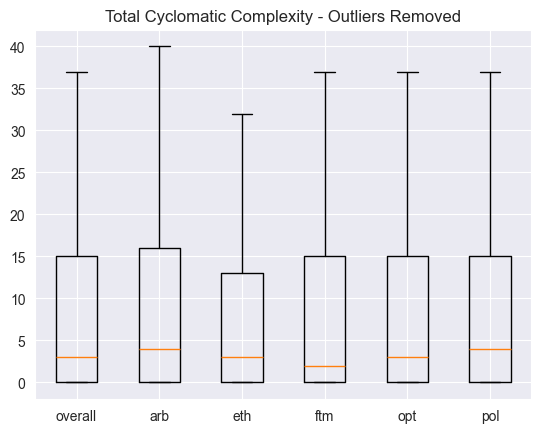

In [5]:
def create_boxplot(df, column, title, show_outliers=True):
    fig = plt.figure()
    plt.title(title)

    data = [df[column]]
    labels = ['overall']
    for name, group in df.groupby('Blockchain'):
        data.append(group[column])
        labels.append(name)
    plt.boxplot(data, tick_labels=labels, showfliers=show_outliers)
    plt.show()

for metric in combined_stats.columns:
    create_boxplot(combined_metrics_df, metric, metric)
    create_boxplot(combined_metrics_df, metric, metric + ' - Outliers Removed', False)

## Average Metrics

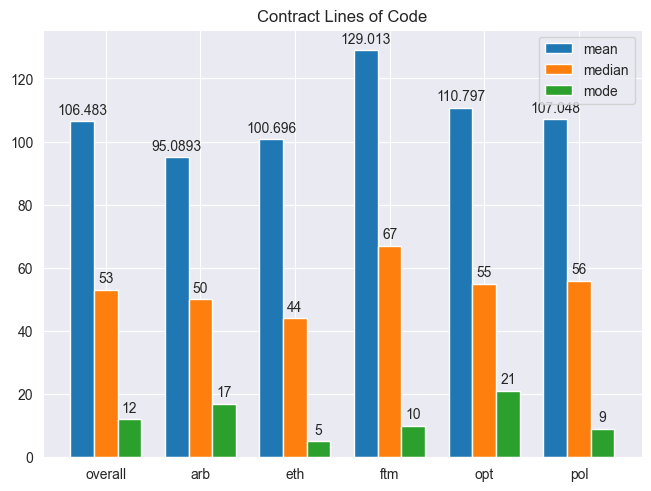

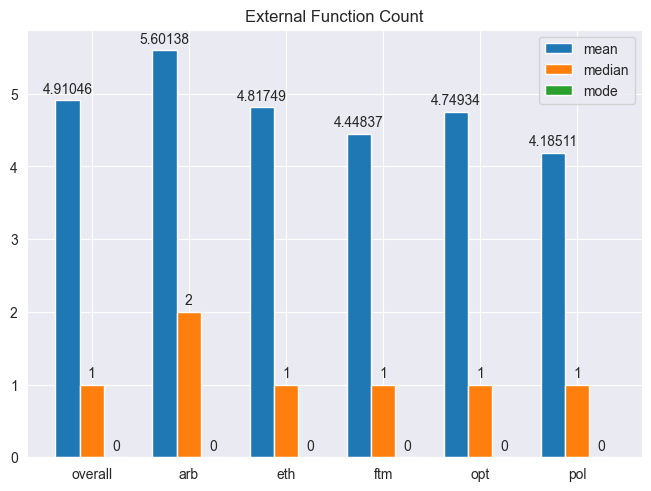

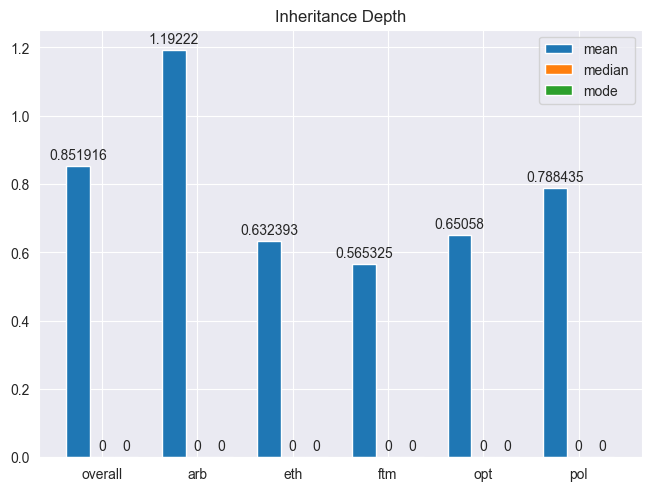

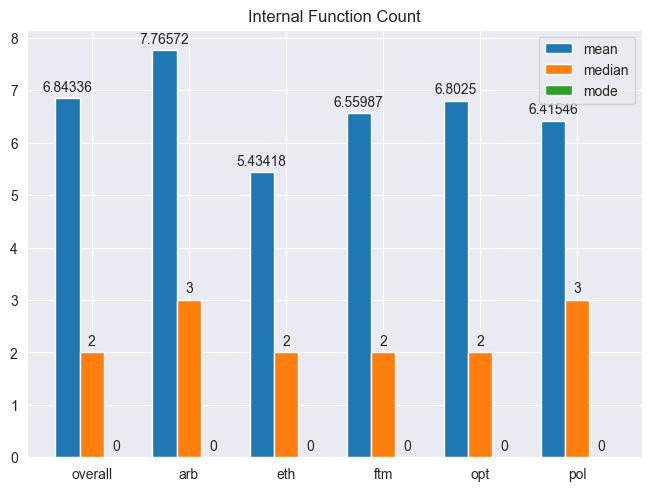

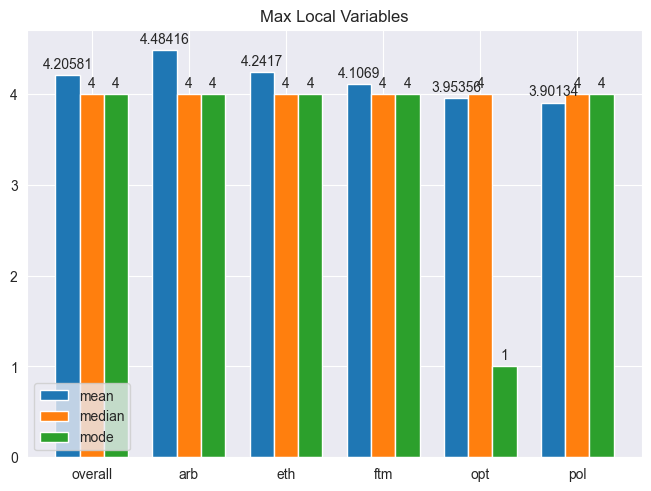

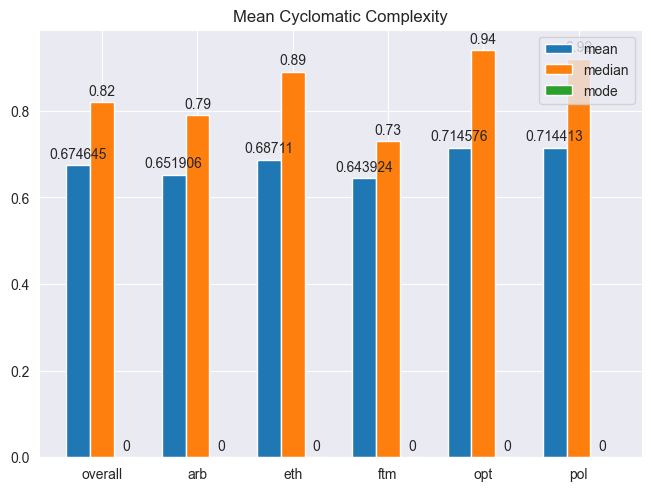

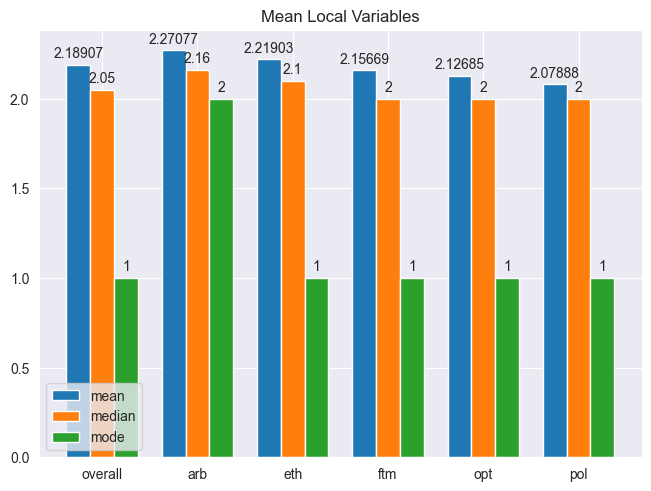

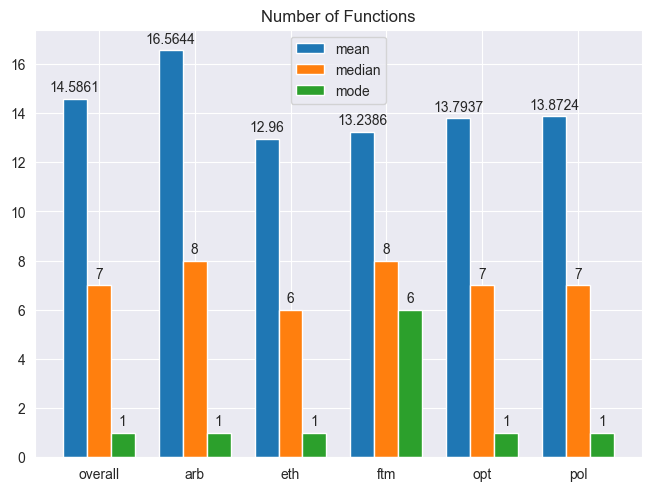

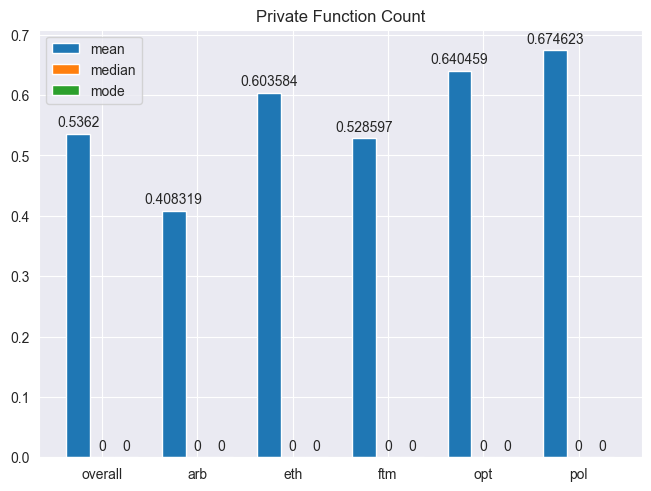

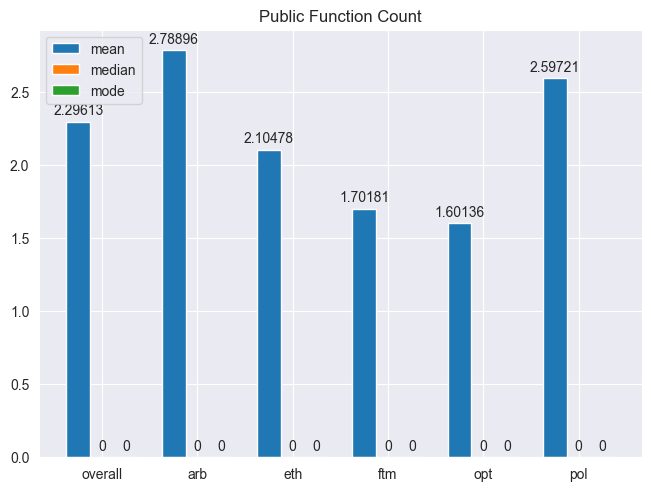

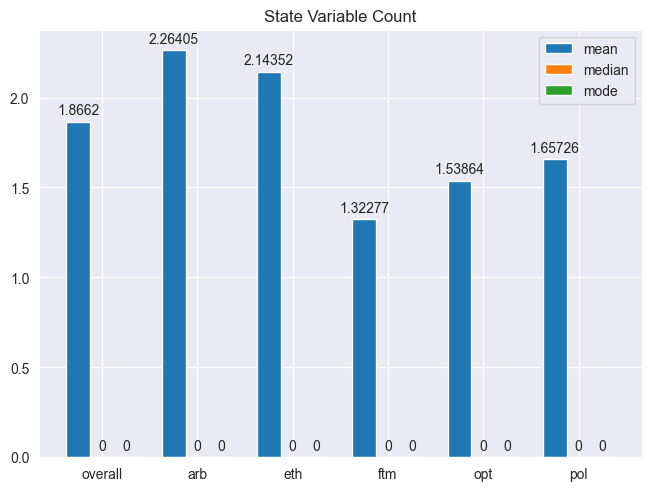

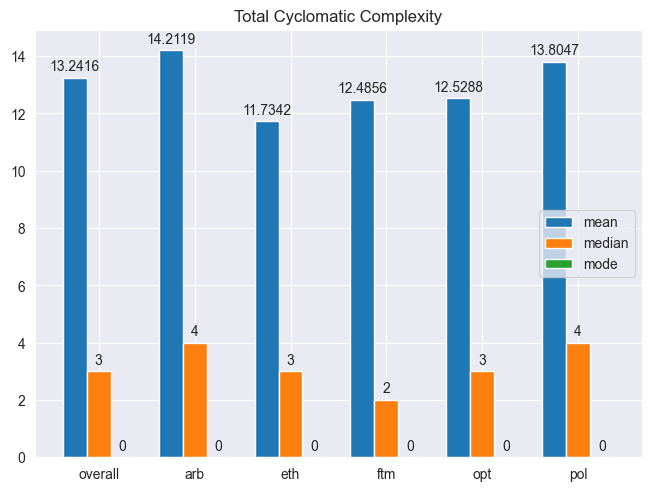

In [6]:
def plot_averages(df, metric, title):
    means = [df[metric].mean()]
    medians = [df[metric].median()]
    modes = [df[metric].mode().iloc[0]]
    labels = ['overall']

    for name, group in df.groupby('Blockchain'):
        means.append(group[metric].mean())
        medians.append(group[metric].median())
        modes.append(group[metric].mode().iloc[0])
        labels.append(name)

    data = {
        'mean': means,
        'median': medians,
        'mode': modes
    }

    label_loc = np.arange(len(labels))
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for key, value in data.items():
        offset = width * multiplier
        rects = ax.bar(label_loc + offset, value, width, label=key)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xticks(label_loc + width, labels)

    plt.title(title)
    plt.legend()
    plt.show()

for metric in combined_stats.columns:
    plot_averages(combined_metrics_df, metric, metric)


## Correlation Analysis

### Setup

In [7]:
metrics = combined_metrics_df.columns.drop('Blockchain')
patterns = combined_patterns_df.columns.drop('Blockchain')
# drop patterns removed from the final analysis
patterns = patterns.drop('Multi Return')
patterns = patterns.drop('State Machine')
patterns = patterns.drop('Permissioned')
patterns = patterns.drop('Permissionless')


### Point-Biserial Correlation

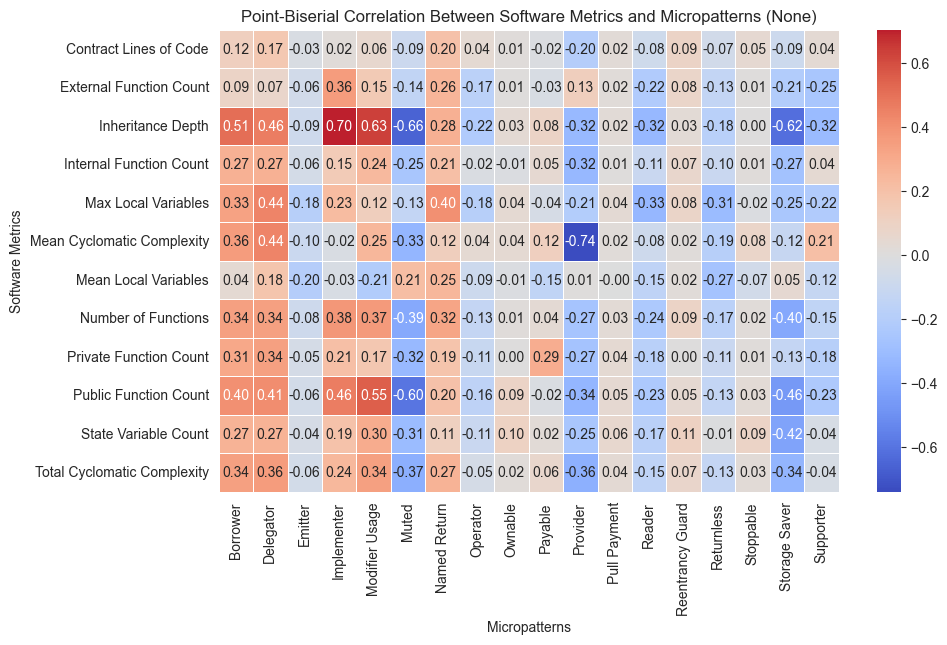

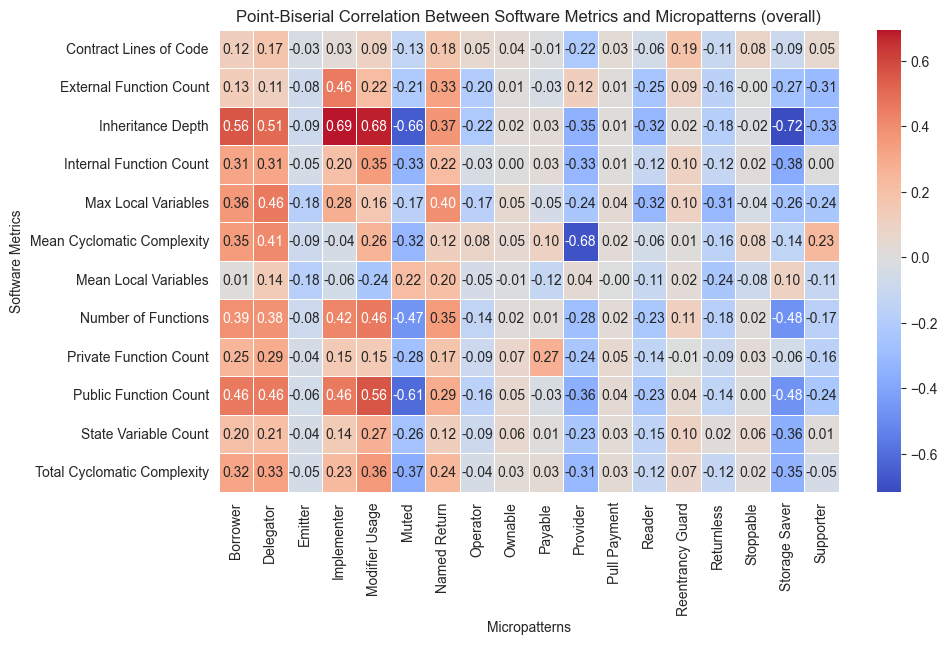

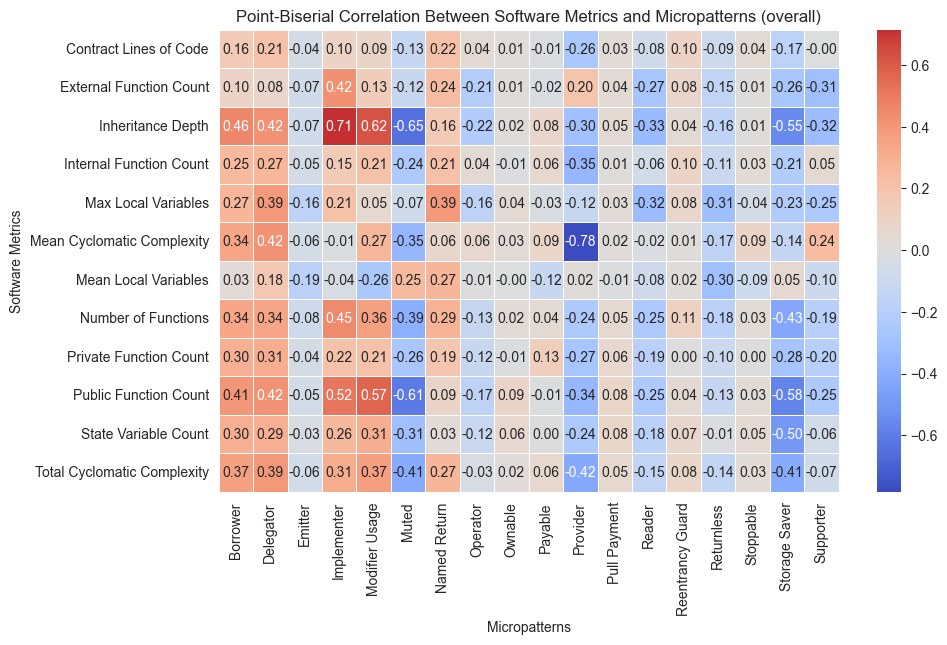

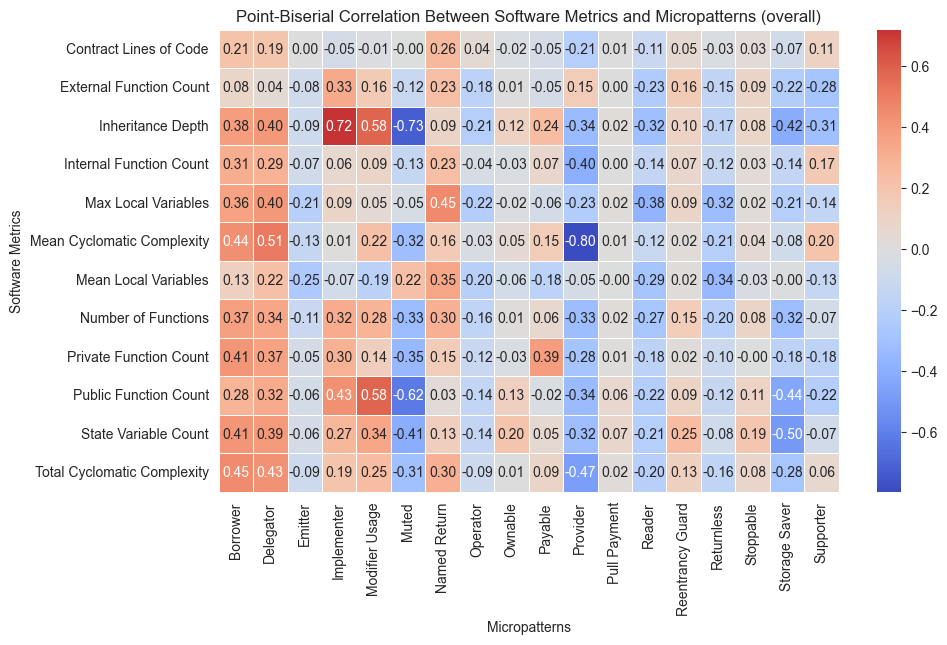

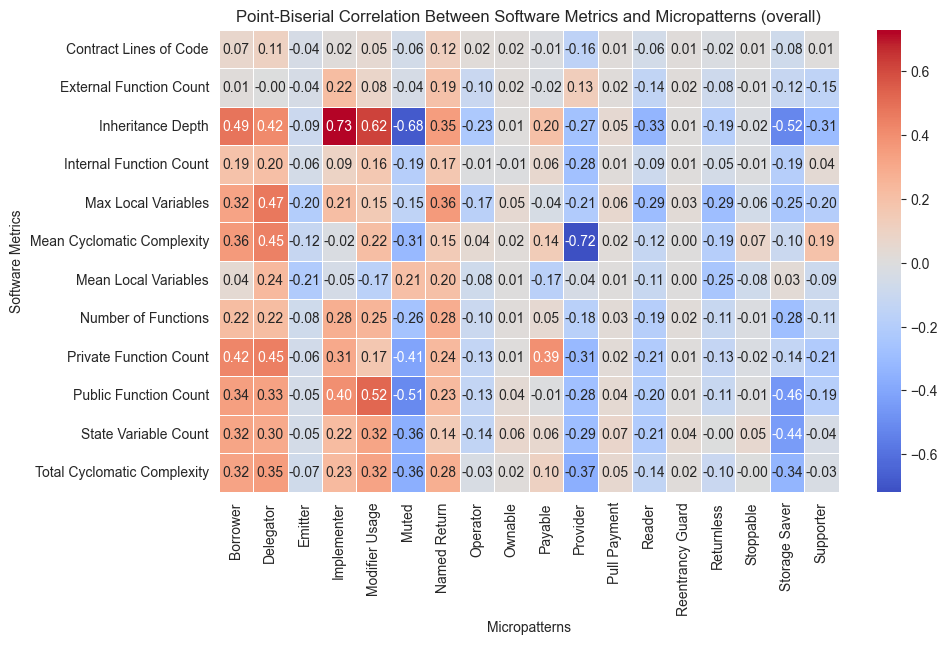

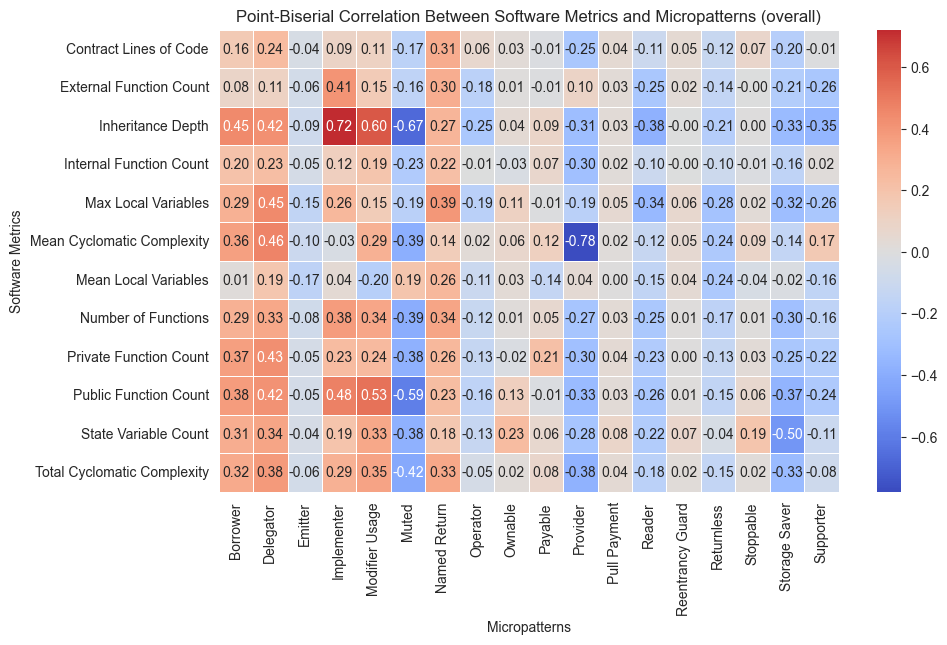

In [8]:
def point_biserial_corr(blockchain = None):
    corr_matrix = pd.DataFrame(index=metrics, columns=patterns)

    title = "Point-Biserial Correlation Between Software Metrics and Micropatterns"

    if blockchain:
        # complete analysis for a specific blockchain
        blockchain_metrics_df = combined_metrics_df[combined_metrics_df['Blockchain'] == blockchain]
        blockchain_patterns_df = combined_patterns_df[combined_patterns_df['Blockchain'] == blockchain]
        title = f"{title} (overall)"
    else:
        # complete analysis for a specific blockchain
        blockchain_metrics_df = combined_metrics_df
        blockchain_patterns_df = combined_patterns_df
        title = f"{title} ({blockchain})"

    for pattern in patterns:
        for metric in metrics:
            r, p = stats.pointbiserialr(blockchain_metrics_df[metric], blockchain_patterns_df[pattern])
            corr_matrix.loc[metric, pattern] = r

    corr_matrix = corr_matrix.astype(float)

    # Plot correlation matrix as a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)

    # Labels and title
    plt.title(title)
    plt.xlabel("Micropatterns")
    plt.ylabel("Software Metrics")

    # Show the plot
    plt.show()

point_biserial_corr()
for blockchain in blockchains:
    point_biserial_corr(blockchain)


### Spearman

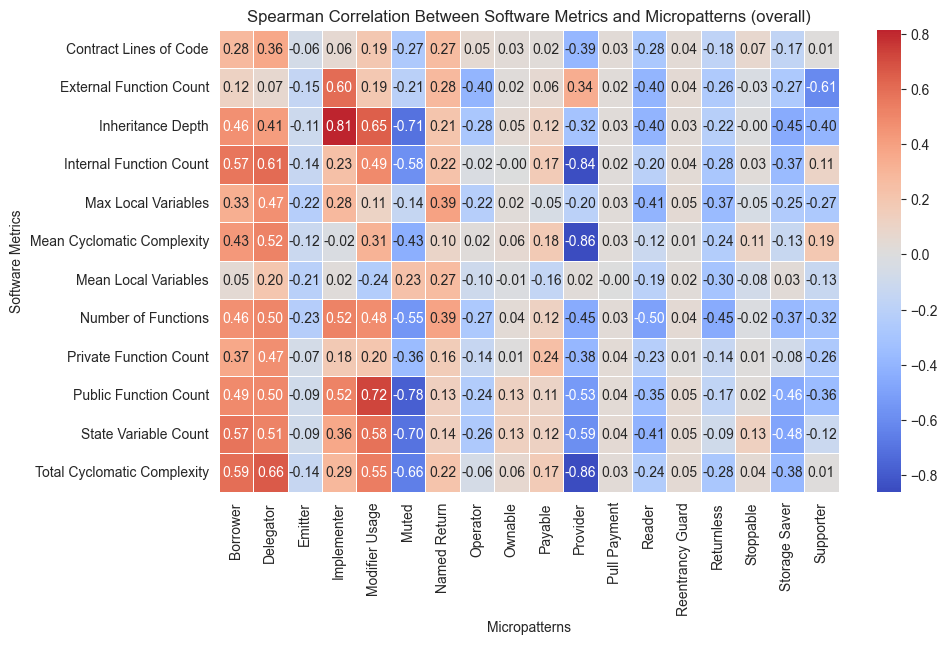

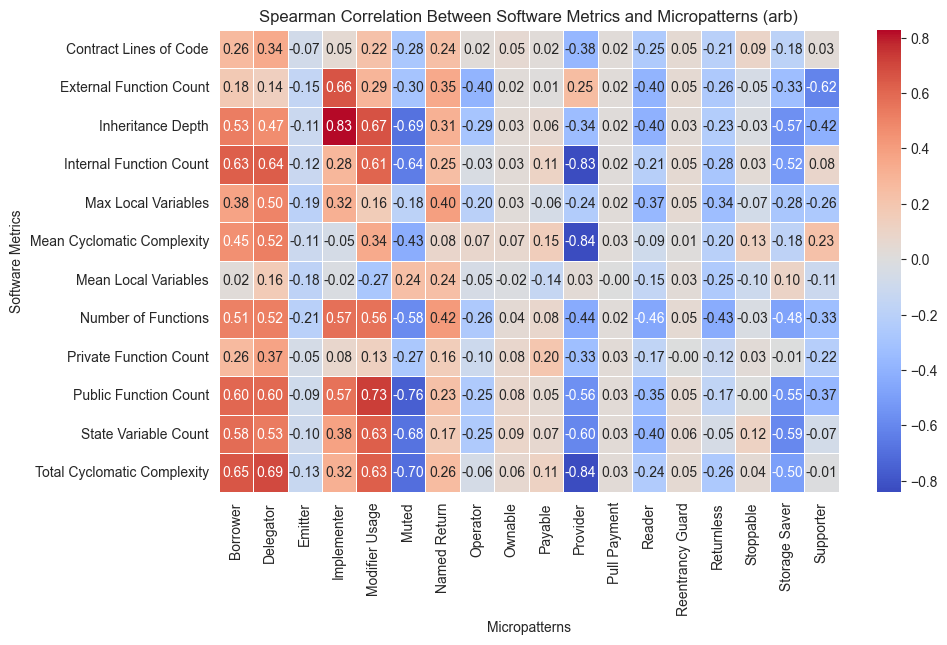

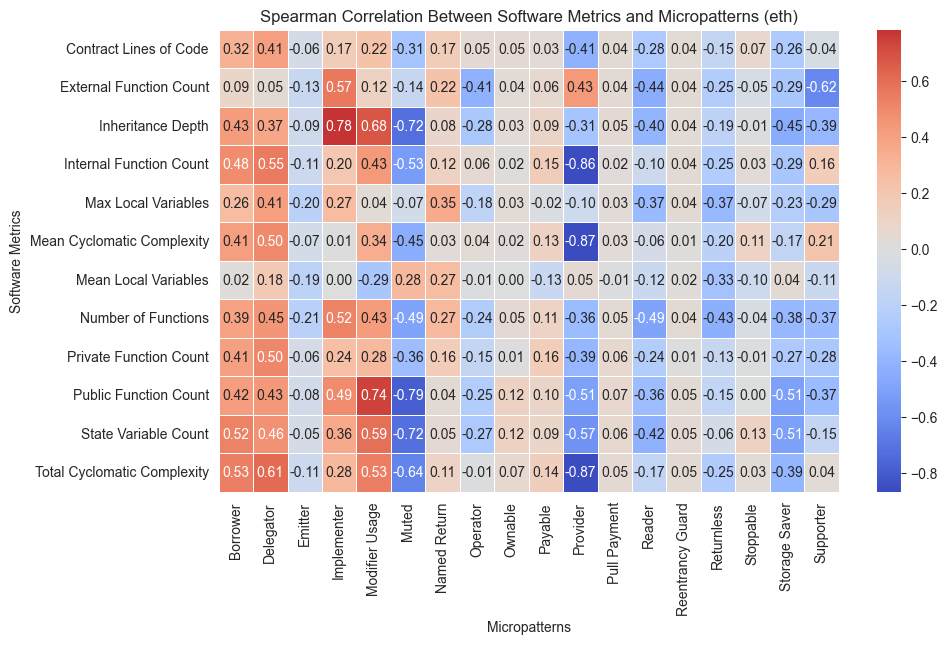

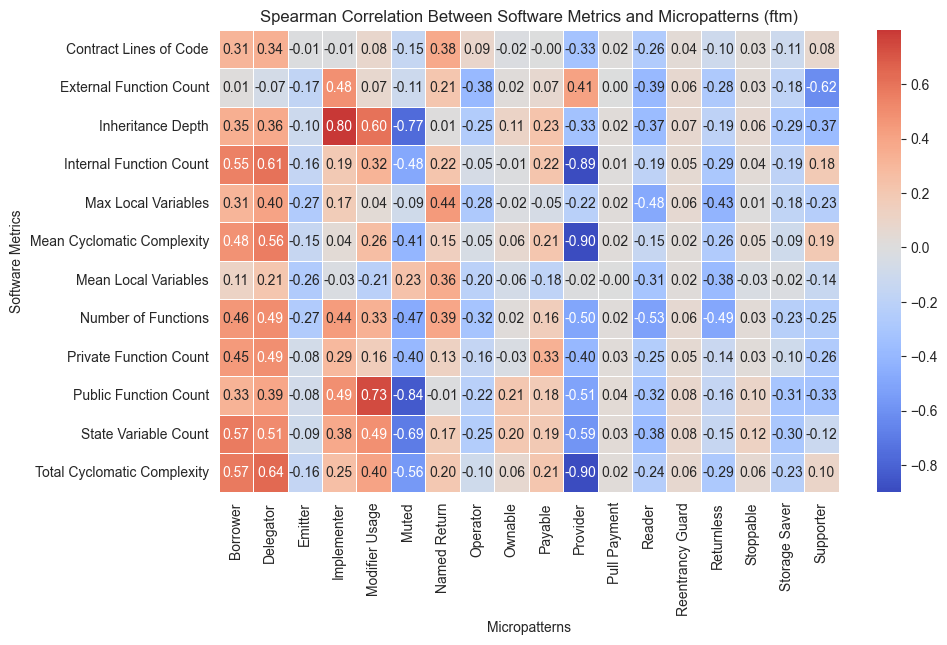

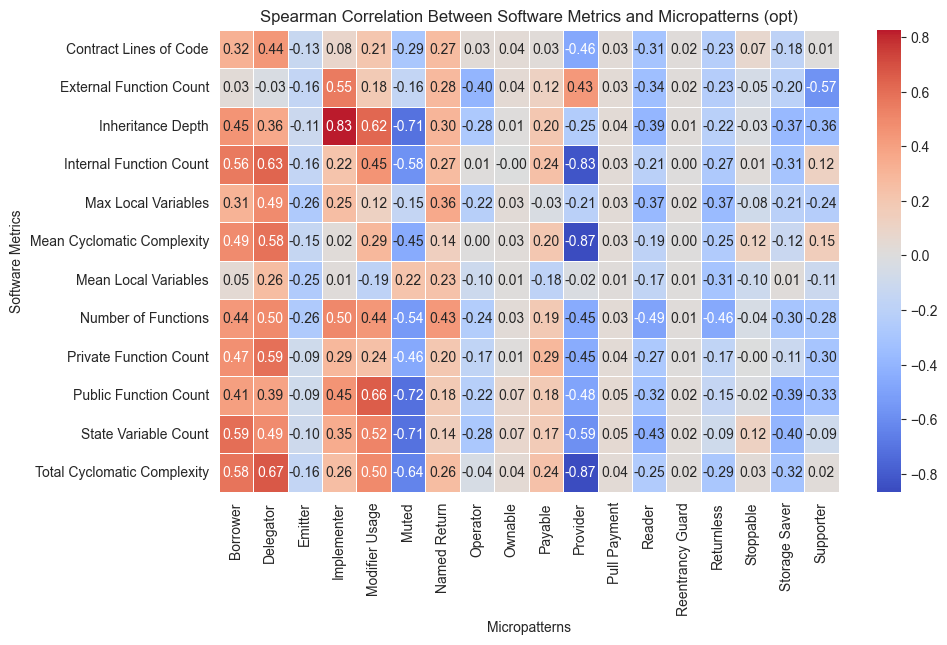

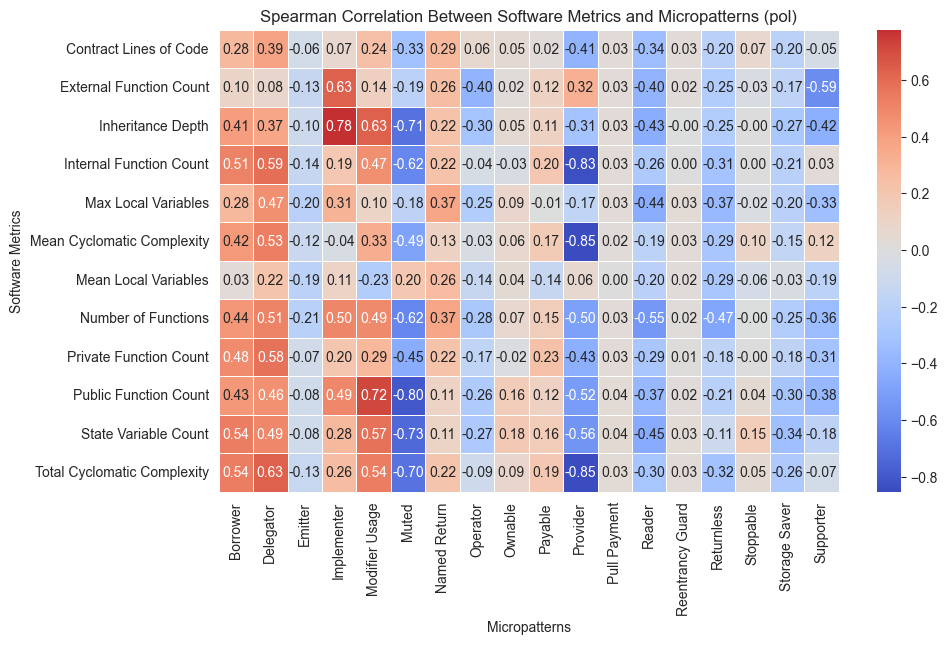

In [9]:
def spearman_corr(blockchain=None):
    """
    Computes Spearman correlation between software metrics and micropatterns.
    If a blockchain is specified, it computes the correlation for that blockchain only.
    """
    corr_matrix = pd.DataFrame(index=metrics, columns=patterns)

    title = "Spearman Correlation Between Software Metrics and Micropatterns"

    if blockchain:
        blockchain_metrics_df = combined_metrics_df[combined_metrics_df['Blockchain'] == blockchain]
        blockchain_patterns_df = combined_patterns_df[combined_patterns_df['Blockchain'] == blockchain]
        title = f"{title} ({blockchain})"
    else:
        blockchain_metrics_df = combined_metrics_df
        blockchain_patterns_df = combined_patterns_df
        title = f"{title} (overall)"

    for pattern in patterns:
        for metric in metrics:
            r, p = stats.spearmanr(blockchain_metrics_df[metric], blockchain_patterns_df[pattern])
            corr_matrix.loc[metric, pattern] = r

    corr_matrix = corr_matrix.astype(float)

    # Plot correlation matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
    plt.title(title)
    plt.xlabel("Micropatterns")
    plt.ylabel("Software Metrics")
    plt.show()

# Compute Spearman correlation for overall and per blockchain
spearman_corr()
for blockchain in blockchains:
    spearman_corr(blockchain)


### Kruskal-Wallis Test

In [15]:
def is_normal(data):
    _, p = stats.normaltest(data, nan_policy='omit')
    return p > 0.05  # p > 0.05 means data is approximately normal

def kruskal_wallis():
    significant_metrics = []
    for metric in metrics:
        groups = [group[metric] for name, group in combined_metrics_df.groupby('Blockchain')]
        h_stat, p_val = stats.kruskal(*groups)
        print(f"{metric}: Kruskal-Wallis H = {h_stat:.2f}, p = {p_val:.2f} (Non-parametric)")
        if p_val < 0.05:
            significant_metrics.append(metric)
    return significant_metrics

kw_metrics = kruskal_wallis()


Contract Lines of Code: Kruskal-Wallis H = 1517.30, p = 0.00 (Non-parametric)
External Function Count: Kruskal-Wallis H = 4188.78, p = 0.00 (Non-parametric)
Inheritance Depth: Kruskal-Wallis H = 8233.39, p = 0.00 (Non-parametric)
Internal Function Count: Kruskal-Wallis H = 1011.38, p = 0.00 (Non-parametric)
Max Local Variables: Kruskal-Wallis H = 4437.89, p = 0.00 (Non-parametric)
Mean Cyclomatic Complexity: Kruskal-Wallis H = 1273.76, p = 0.00 (Non-parametric)
Mean Local Variables: Kruskal-Wallis H = 1716.99, p = 0.00 (Non-parametric)
Number of Functions: Kruskal-Wallis H = 1608.55, p = 0.00 (Non-parametric)
Private Function Count: Kruskal-Wallis H = 2900.88, p = 0.00 (Non-parametric)
Public Function Count: Kruskal-Wallis H = 3703.15, p = 0.00 (Non-parametric)
State Variable Count: Kruskal-Wallis H = 3534.40, p = 0.00 (Non-parametric)
Total Cyclomatic Complexity: Kruskal-Wallis H = 710.17, p = 0.00 (Non-parametric)


### Dunn's Test

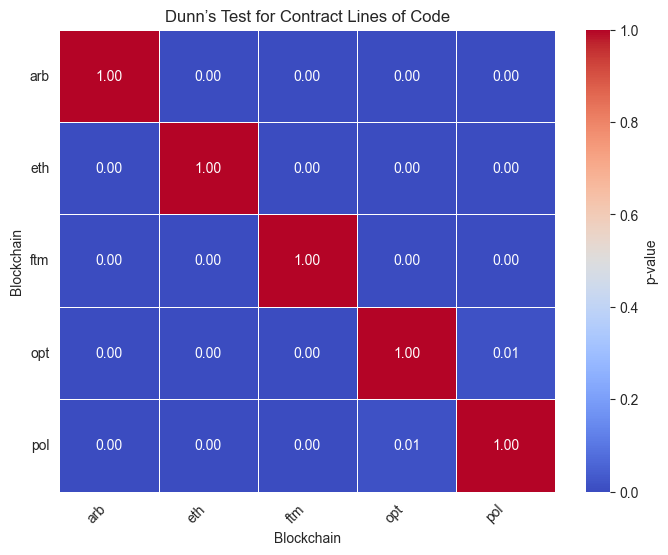

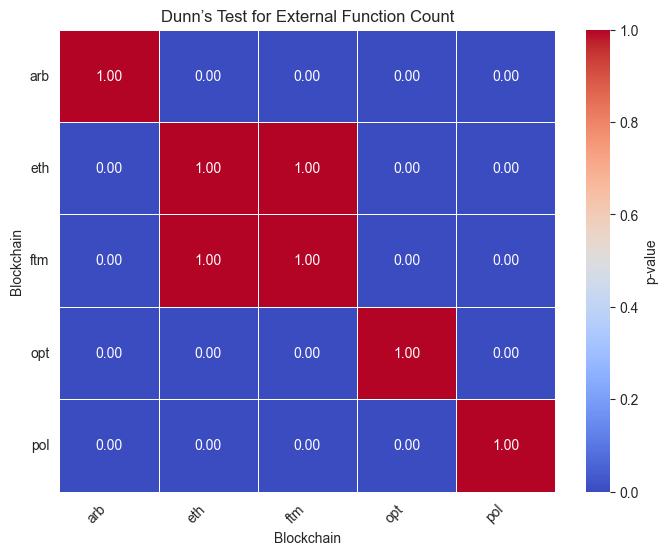

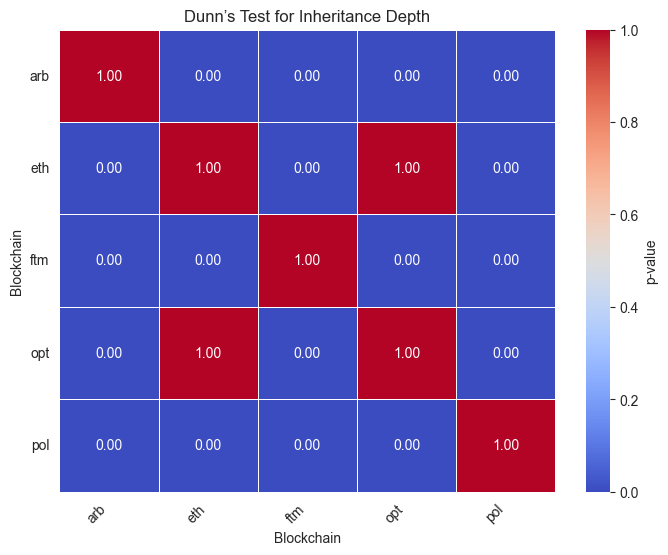

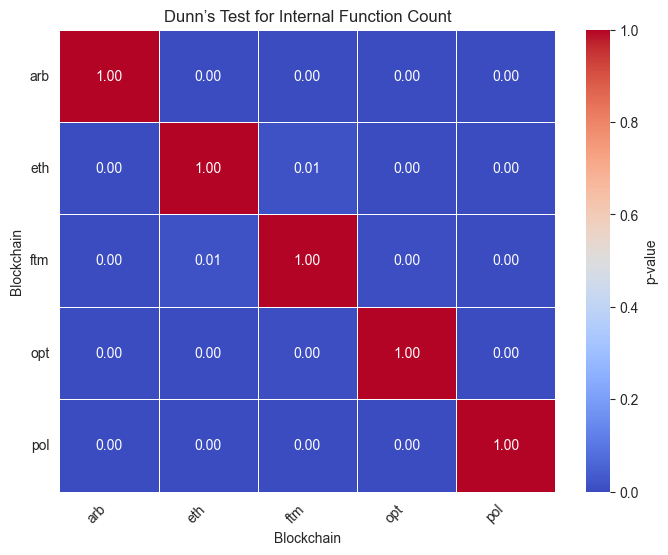

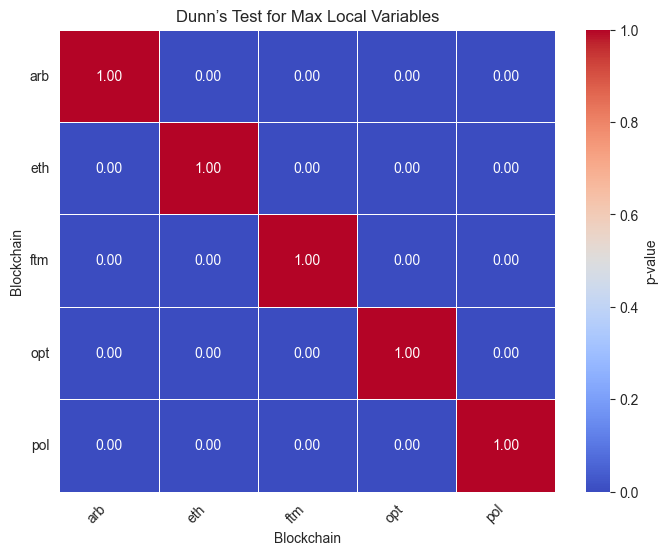

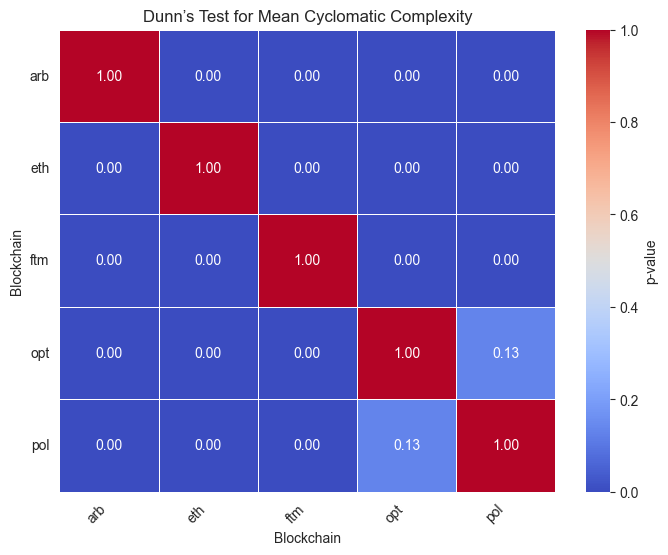

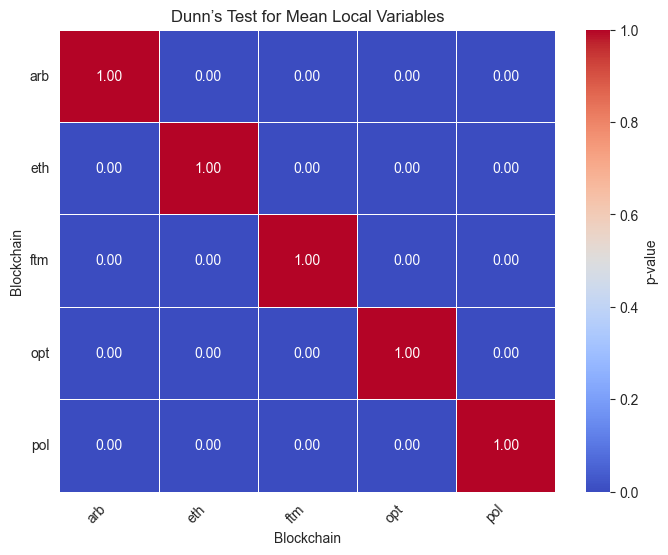

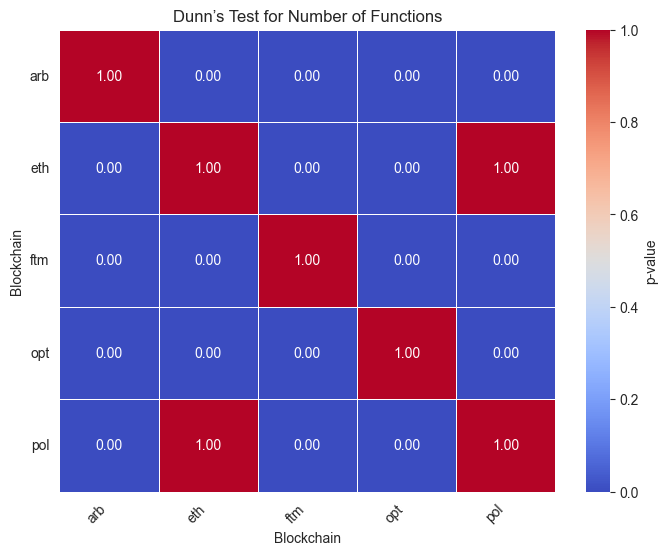

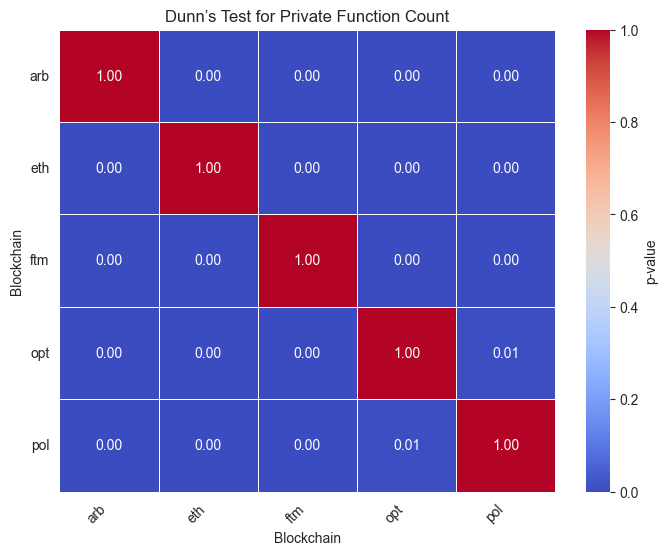

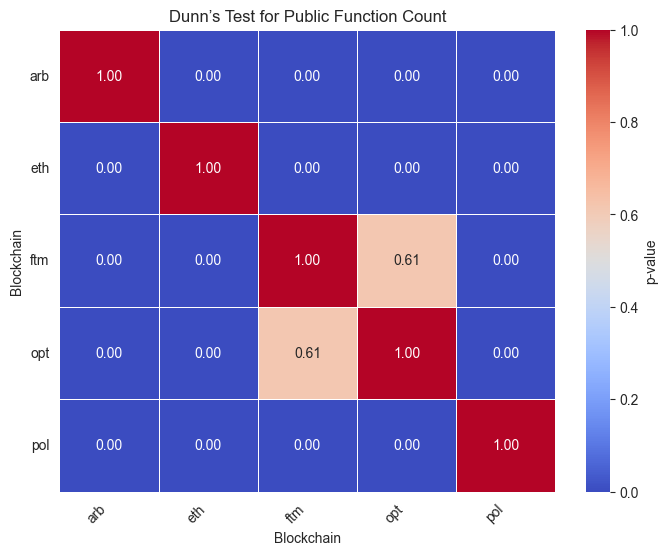

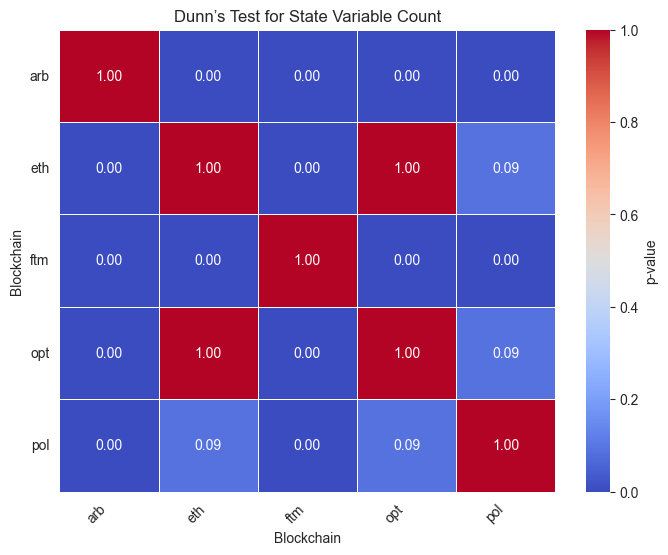

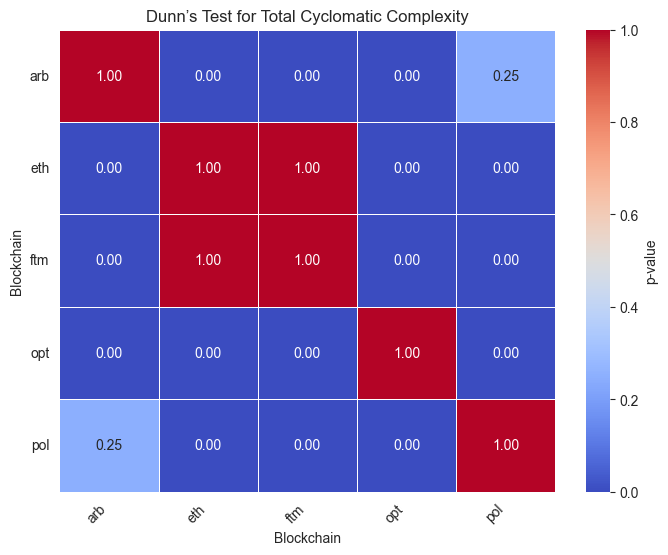

In [16]:
def dunns_test():
    dunn_results = {}
    for metric in kw_metrics:
        posthoc_matrix = posthoc_dunn(combined_metrics_df, val_col=metric, group_col='Blockchain', p_adjust='bonferroni')
        dunn_results[metric] = posthoc_matrix

    # Display Dunn’s test results
    for metric, result in dunn_results.items():
        plt.figure(figsize=(8, 6))
        sns.heatmap(result, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, linewidths=0.5,
                    cbar_kws={'label': 'p-value'})

        plt.title(f"Dunn’s Test for {metric}")
        plt.xlabel("Blockchain")
        plt.ylabel("Blockchain")
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)

        plt.show()

dunns_test()